# Thyroid Tumor Classification
In this project, thyroid ultrasound images are used to classify between bengin and cancer tumors. The only preprocessing done here is to resize the images to 256x256 to be fed into the neural network. Otherwise, the images are not de-identified, and images consists of many ultrasound artifacts

In [2]:
import os
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd

from random import sample

import matplotlib.pyplot as plt
%matplotlib inline

## Keras
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.optimizers import Adam, SGD, Adadelta, Nadam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import Sequence
from keras import backend as K

from keras.applications.densenet import DenseNet121 as base_network1
from sklearn.model_selection import StratifiedKFold
from skimage.transform import resize
import math
from pathlib import Path
import pydicom
import itertools

## MultiGPU Code
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))
import keras.utils.training_utils
from keras.utils import multi_gpu_model
gdev = keras.utils.training_utils._get_available_devices()
gdev_count = 0
for i, n in enumerate(gdev):
    if 'device:GPU' in n:
        gdev_count+=1
if gdev_count > 0:
    print('Found {} GPUs, will attempt to use all of them.'.format(gdev_count))
else:
    gdev_count=1
    print('Did not find any GPUs, this will be SLOW!')

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 8 GPUs, will attempt to use all of them.


# Load Data

In [3]:
data = pd.read_csv('/media/share/data/thyroid/subinfo/cleaned.csv')
print(data.head())
print(data.shape)

         ID  Cancer
0  22404884       0
1  26152292       1
2  20823486       0
3    780001       1
4  22215276       0
(818, 2)


In [4]:
img_rows = 256
img_cols = 256
session_name = 'thyroid_'

In [5]:
n_folds = 5
skf = StratifiedKFold(n_folds, shuffle=True, random_state=np.random)
for train_index, test_index in skf.split(np.arange(len(data)), data['Cancer']):
    break

# Build Datasets

In [6]:
def img_preproc(img):
    
    from skimage.color import rgb2gray
    from skimage.filters import threshold_otsu
    from skimage.morphology import closing, square
    from skimage.measure import label, regionprops
    from skimage.segmentation import clear_border
    from scipy.ndimage.morphology import binary_fill_holes
    from skimage.transform import resize
    
    img_rows = 256
    img_cols = 256
    
    im = rgb2gray(img)
    thresh = threshold_otsu(im)
    bw = closing(im > thresh, square(3))
    cleared = clear_border(bw)
    
    # mask
    step1 = im * ~cleared
    step2 = threshold_otsu(step1)
    step3 = closing(step1 > step2, square(10))
    step4 = binary_fill_holes(step3)
    
    # search largest area
    label_img = label(step4)
    
    bbarea = []
    for region in regionprops(label_img):
        bbarea.append(region.area)
    
    minr, minc, maxr, maxc = regionprops(label_img)[bbarea.index(np.max(bbarea))].bbox
    crop_img = resize(im[minr+32:maxr, minc:maxc], [img_rows, img_cols], mode='constant')
    
    return crop_img

def build_dataset(x):
    images = []
    labels = []
    for p in Path('/media/share/data/thyroid/thyroid_' + ('cancer' if int(x[1].Cancer) else 'healthy')).glob(str(x[1].ID) + '*/*.dcm'):
        dcm = pydicom.dcmread(str(p), force=True)
        # Some dicom files have multiple images...
        if len(dcm.pixel_array.shape) > 3:
            for pa in dcm.pixel_array:
                if dcm.PlanarConfiguration > 1:
                    images += [img_preproc(np.transpose(pa, (2,0,1)).reshape(dcm.Rows, dcm.Columns, dcm.SamplesPerPixel))]
                else:
                    images += [img_preproc(pa)]
                labels += [x[1].Cancer]
        # Single images
        else:
            if dcm.PlanarConfiguration > 1:
                images += [img_preproc(np.transpose(dcm.pixel_array, (2,0,1)).reshape(dcm.Rows, dcm.Columns, dcm.SamplesPerPixel))]
            else:
                images += [img_preproc(dcm.pixel_array)]
            labels += [x[1].Cancer]
    return images, labels

In [ ]:
from keras.utils import to_categorical

with Pool(cpu_count()) as pool:
    print('Importing Training Set')
    train_imgs, train_labels = zip(*pool.map(build_dataset, data.iloc[train_index].iterrows()))
    train_imgs = list(itertools.chain(*train_imgs))
    train_labels = list(itertools.chain(*train_labels))
    print('Importing Validation Set')
    val_imgs, val_labels = zip(*pool.map(build_dataset, data.iloc[test_index].iterrows()))
    val_imgs = list(itertools.chain(*val_imgs))
    val_labels = list(itertools.chain(*val_labels))

Importing Training Set


In [ ]:
# Check training and validation sizes
print('Training Images:', len(train_imgs))
print('Validation Images:', len(val_imgs))

In [ ]:
# Show some sample images @ken
from random import sample

fig = plt.figure(figsize=(16, 16))
for i, n in enumerate(sample(list(train_imgs), 25)):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(n)

# Build Neural Network

In [9]:
# dense 121
K.clear_session()

base_model = base_network1(include_top=False, pooling=None, input_shape=(img_rows, img_cols, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(2, activation='softmax')(x)
smodel = Model(base_model.input, x)

# MultiGPU Code
smodel.summary()
if gdev_count > 1:
    model = multi_gpu_model(smodel, gdev_count)
    model.summary()
else:
    model = smodel

30015488/30011760 [==============================] - 61s 2us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
___________________________________________

In [17]:
# dense 201
from keras.applications.densenet import DenseNet201 as base_network2
K.clear_session()

base_model = base_network2(include_top=False, pooling=None, input_shape=(img_rows,img_cols,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(2, activation='softmax')(x)
smodel = Model(base_model.input, x)

# MultiGPU Code
smodel.summary()
if gdev_count > 1:
    model = multi_gpu_model(smodel, gdev_count)
    model.summary()
else:
    model = smodel

76398592/76391848 [==============================] - 298s 4us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
__________________________________________

In [28]:
# inception-resnet-v2
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as base_network3
K.clear_session()

base_model = base_network3(include_top=False, pooling=None, input_shape=(img_rows,img_cols,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1, activation='sigmoid')(x)
smodel = Model(base_model.input, x)

# MultiGPU Code
smodel.summary()
if gdev_count > 1:
    model = multi_gpu_model(smodel, gdev_count)
    model.summary()
else:
    model = smodel

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [30]:
# resnet 101
from keras.applications.resnet101 import ResNet101 as base_network4

K.clear_session()

base_model = base_network4(include_top=False, pooling=None, input_shape=(img_rows,img_cols,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1, activation='sigmoid')(x)
smodel = Model(base_model.input, x)

# MultiGPU Code
smodel.summary()
if gdev_count > 1:
    model = multi_gpu_model(smodel, gdev_count)
    model.summary()
else:
    model = smodel

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

# Training

In [ ]:
from keras.utils import to_categorical

def gen(x, y, b):
    while True:
        x_out, y_out = zip(*sample(list(zip(x, y)), b))
        yield np.asarray(x_out), to_categorical(y_out)

In [ ]:
model_checkpoint = ModelCheckpoint(session_name+'den121_acc.hdf5',
                                   monitor='val_acc', save_best_only=True, save_weights_only=True)
model_checkpoint2 = ModelCheckpoint(session_name+'den121_loss.hdf5',
                                    monitor='val_loss', save_best_only=True, save_weights_only=True)
# model_reducelr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8)
model_earlystop = EarlyStopping(patience=64, monitor='val_acc')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 24 * gdev_count
train_history = model.fit_generator(gen(train_imgs, train_labels, batch_size),
                                    steps_per_epoch=8, epochs=2**7,
                                    validation_data=gen(val_imgs, val_labels, batch_size),
                                    validation_steps=4,
                                    verbose=2, callbacks=[model_checkpoint, model_earlystop, model_checkpoint2])

In [18]:
model_checkpoint = ModelCheckpoint(session_name+'den201_acc.hdf5',
                                   monitor='val_acc', save_best_only=True, save_weights_only=True)
model_checkpoint2 = ModelCheckpoint(session_name+'den201_loss.hdf5',
                                    monitor='val_loss', save_best_only=True, save_weights_only=True)

# model_reducelr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8)
# model_earlystop = EarlyStopping(patience=64, monitor='val_acc')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 24 * gdev_count
train_history = model.fit_generator(gen(train_imgs, train_labels, batch_size),
                                    steps_per_epoch=8, epochs=2**7,
                                    validation_data=gen(val_imgs, val_labels, batch_size),
                                    validation_steps=4,
                                    verbose=2, callbacks=[model_checkpoint, model_earlystop, model_checkpoint2, model_reducelr])

NameError: name 'model_reducelr' is not defined

In [29]:
model_checkpoint = ModelCheckpoint(session_name+'inrv2_acc.hdf5',
                                   monitor='val_acc', save_best_only=True, save_weights_only=True)
model_checkpoint2 = ModelCheckpoint(session_name+'inrv2_loss.hdf5',
                                    monitor='val_loss', save_best_only=True, save_weights_only=True)
# model_reducelr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8)
# model_earlystop = EarlyStopping(patience=64, monitor='val_acc')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 24 * gdev_count
train_history = model.fit_generator(gen(train_imgs, train_labels, batch_size),
                                    steps_per_epoch=128, epochs=2**7,
                                    validation_data=gen(val_imgs, val_labels, batch_size),
                                    validation_steps=128,
                                    verbose=2, callbacks=[model_checkpoint, model_earlystop, model_checkpoint2, model_reducelr])

Epoch 1/128
 - 373s - loss: 0.4156 - acc: 0.7994 - val_loss: 1.6149 - val_acc: 0.4683
Epoch 2/128
 - 296s - loss: 0.1345 - acc: 0.9498 - val_loss: 0.8641 - val_acc: 0.7710
Epoch 3/128
 - 297s - loss: 0.0676 - acc: 0.9765 - val_loss: 1.5457 - val_acc: 0.6799
Epoch 4/128
 - 296s - loss: 0.0479 - acc: 0.9832 - val_loss: 0.9832 - val_acc: 0.7356
Epoch 5/128
 - 297s - loss: 0.0318 - acc: 0.9887 - val_loss: 1.0918 - val_acc: 0.7475
Epoch 6/128
 - 297s - loss: 0.0238 - acc: 0.9922 - val_loss: 1.8743 - val_acc: 0.6294
Epoch 7/128
 - 297s - loss: 0.0220 - acc: 0.9922 - val_loss: 1.3277 - val_acc: 0.7491
Epoch 8/128
 - 296s - loss: 0.0259 - acc: 0.9915 - val_loss: 1.7114 - val_acc: 0.6996
Epoch 9/128
 - 296s - loss: 0.0176 - acc: 0.9944 - val_loss: 2.4967 - val_acc: 0.4517
Epoch 10/128
 - 298s - loss: 0.0248 - acc: 0.9915 - val_loss: 1.3655 - val_acc: 0.7196
Epoch 11/128
 - 296s - loss: 0.0148 - acc: 0.9945 - val_loss: 1.2156 - val_acc: 0.6929
Epoch 12/128
 - 298s - loss: 0.0139 - acc: 0.9953 - 

In [31]:
model_checkpoint = ModelCheckpoint(session_name+'res50_acc.hdf5',
                                   monitor='val_acc', save_best_only=True, save_weights_only=True)
model_checkpoint2 = ModelCheckpoint(session_name+'res50_loss.hdf5',
                                    monitor='val_loss', save_best_only=True, save_weights_only=True)
# model_reducelr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8)
# model_earlystop = EarlyStopping(patience=64, monitor='val_acc')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 24 * gdev_count
train_history = model.fit_generator(gen(train_imgs, train_labels, batch_size),
                                    steps_per_epoch=128, epochs=2**7,
                                    validation_data=gen(val_imgs, val_labels, batch_size),
                                    validation_steps=128,
                                    verbose=2, callbacks=[model_checkpoint, model_earlystop, model_checkpoint2, model_reducelr])

Epoch 1/128
 - 195s - loss: 0.5175 - acc: 0.7316 - val_loss: 1.1343 - val_acc: 0.6733
Epoch 2/128
 - 167s - loss: 0.2161 - acc: 0.9135 - val_loss: 1.0721 - val_acc: 0.6303
Epoch 3/128
 - 166s - loss: 0.0862 - acc: 0.9683 - val_loss: 1.2174 - val_acc: 0.6916
Epoch 4/128
 - 166s - loss: 0.0615 - acc: 0.9780 - val_loss: 1.2451 - val_acc: 0.7198
Epoch 5/128
 - 167s - loss: 0.0353 - acc: 0.9879 - val_loss: 1.2051 - val_acc: 0.6772
Epoch 6/128
 - 166s - loss: 0.0189 - acc: 0.9936 - val_loss: 1.8171 - val_acc: 0.6799
Epoch 7/128
 - 167s - loss: 0.0234 - acc: 0.9921 - val_loss: 1.6224 - val_acc: 0.7277
Epoch 8/128
 - 166s - loss: 0.0338 - acc: 0.9881 - val_loss: 1.3118 - val_acc: 0.7302
Epoch 9/128
 - 167s - loss: 0.0214 - acc: 0.9919 - val_loss: 1.8705 - val_acc: 0.6848
Epoch 10/128
 - 166s - loss: 0.0072 - acc: 0.9977 - val_loss: 3.3494 - val_acc: 0.5248
Epoch 11/128
 - 167s - loss: 0.0093 - acc: 0.9969 - val_loss: 2.0924 - val_acc: 0.6769
Epoch 12/128
 - 166s - loss: 0.0212 - acc: 0.9925 - 

# Check Training History

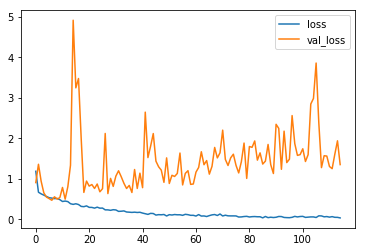

In [15]:
plt.figure()
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

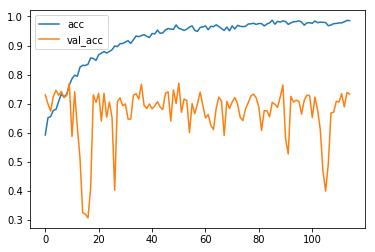

In [16]:
plt.figure()
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.legend(['acc', 'val_acc'])

# Model Evaluation